# MODEL 1 RANDOM FOREST VS MLP!

In [1]:
#! pip3 install auto-sklearn

import os
os.chdir('..')

import pandas as pd
import os
import numpy as np
RNDSEED = np.random.seed(39)
PRECISION = 4 # 3 of digits to keep after the decimal point
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, cohen_kappa_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
RUNNING_ON_COLAB = False # we assume running on CoLab! Change to False if running locally.

# *italicized text*

## mount gdrive
#from google.colab import drive#
#drive.mount("/content/gdrive")

# If running locally, define current working path
path = os.getcwd()

# If Google colab
if RUNNING_ON_COLAB:
    path = "/content/gdrive/My Drive/Colab Notebooks/RandomForest_FeatureData"

print(path)

# define current data path. This is after we did classification. We have done some
# cleaning already.
data_path = path + '/fl_testbed/version2/data/initial'
print(data_path)
#/home/jose/FL_AM_Defect-Detection
#/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial

## Play code

# <font color=cyan>The key is to transform the time column! </font>


!cd '/home/jose/FL_AM_Defect-Detection/notebooks/fl_testbed/version2/data/initial' && ls

## start - play code
print(data_path)
csv_file = data_path + '/combined_offset_misalignment.csv'
df_temp = pd.read_csv(csv_file, chunksize=50000) 
df = pd.concat(df_temp, ignore_index=True)

print(df.columns)

df.head(5)

#238722
#DO NOT FORGET SORT VALUES
df1=df.loc[0:238721].sort_values(by='wf_start_time').reset_index()
df2=df.loc[0+238722:0+238722+238722-1].sort_values(by='wf_start_time').reset_index()
df3=df.loc[0+238722+238722:].sort_values(by='wf_start_time').reset_index()

lists=[]
for df in [df1,df2,df3]:
    # Let's find the youngest & oldest timestamp

    df['wf_start_time'] = pd.to_datetime(df['wf_start_time']) # make sure it is datetime

    youngest = min(df.wf_start_time)
    oldest = max(df.wf_start_time)
    print(youngest)
    print(oldest)
    span = oldest - youngest
    print(span)
    print(span.total_seconds())

    ## Using Oldest - current to determine the RUL
    df['rul'] = df['wf_start_time'].apply(lambda x: (oldest - x).total_seconds())
    lists.append(df)



/home/jose/FL_AM_Defect-Detection
/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial
/bin/bash: line 0: cd: /home/jose/FL_AM_Defect-Detection/notebooks/fl_testbed/version2/data/initial: No such file or directory
/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial
Index(['Unnamed: 0', 'wf_start_time', 'S1_CrestFactor_g~g', 'S1_DerivedPeak_g',
       'S1_Peak~Peak_g', 'S1_RMS_g', 'S1_TruePeak_g', 'S1_HighFrequency_grms',
       'S1_Kurtosis_g~g', 'S2_CrestFactor_g~g', 'S2_DerivedPeak_g',
       'S2_Peak~Peak_g', 'S2_RMS_g', 'S2_TruePeak_g', 'S2_HighFrequency_grms',
       'S2_Kurtosis_g~g', 'S1_temp', 'status'],
      dtype='object')
2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0
2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0
2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0


In [2]:
#THIS MEAN THE M3
df=pd.concat(lists[-1:],ignore_index=True)



# drop Unnamed columns
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]


In [3]:


df.loc[0:238721]




,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,591557,2022-08-09 14:03:22.000007,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,No_Offset,2009308.0
1,591558,2022-08-09 14:03:23.000007,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,No_Offset,2009307.0
2,591559,2022-08-09 14:03:24.000007,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,No_Offset,2009306.0
3,591560,2022-08-09 14:03:25.000007,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,No_Offset,2009305.0
4,591561,2022-08-09 14:03:26.000007,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,No_Offset,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,643079,2022-09-01 20:11:29.000007,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,12.7mm_Offset,21.0
238718,643080,2022-09-01 20:11:30.000007,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,12.7mm_Offset,20.0
238719,643081,2022-09-01 20:11:31.000007,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,12.7mm_Offset,19.0
238720,643082,2022-09-01 20:11:32.000007,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,12.7mm_Offset,18.0


In [4]:

df.loc[0+238722:0+238722+238722-1]



,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


In [5]:

df.loc[0+238722+238722:]


,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


In [6]:



df.columns



# df.head()

df.loc[0:238721]


df.loc[0+238722:0+238722+238722-1]


df.loc[0+238722+238722:] #NOW THIS IS VALIDATION DATA

## RF Regression

## Common imports
import pandas as pd
import numpy as np
import csv
import os

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, cohen_kappa_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
# from pandas_ml import ConfusionMatrix

import matplotlib
import matplotlib.pyplot as plt
plt.style.available
%matplotlib inline

# to make this notebook's output stable across runs
RNDSEED = np.random.seed(39)

### Exploring the data a bit & prep the df

# ## future, let's read the file
# csv_file = data_path + '/combined_offset_misalignment_with_RUL.csv'
# df_temp = pd.read_csv(csv_file, chunksize=50000) 
# big_df = pd.concat(df_temp)

#df = big_df # reset 








#THIS IS THE BEGINNING OF THE FEDERATED CODE!!!!!

# drop unwanted cols
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))] # drop Unnamed
df = df[df.columns.drop(list(df.filter(regex='wf_start_time')))] # drop time column
df = df[df.columns.drop(list(df.filter(regex='rul')))] # drop status column
df = df[df.columns.drop(list(df.filter(regex='index')))] # drop status column



df.shape

df.columns





status_map = {
    "No_Offset": 0,
    "1mm_Offset": 1,
    "3mm_Offset": 2,
    "6.25mm_Offset": 3,
    "12.7mm_Offset": 4,
}

df["status"] = df["status"].map(status_map)



In [7]:





### RF works

# Get X & y
# Naming convention: X as predictors; y as response.
from sklearn.model_selection import train_test_split

y = df['status'] # pop response
X = df.drop('status',axis = 1) # drop response



print (X.shape)
print (X.columns)

## true orignal ones
# data split


#STARTING POINT OF train_cut_split_2!!!




# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = True, random_state = RNDSEED)

# Use the same function above for the validation set
X_train, X_vals, y_train, y_vals = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= RNDSEED,shuffle=True) # 0.25 x 0.8 = 0.2






y_test.shape

X_train.dtypes


y_train.dtypes





(238722, 15)
Index(['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g',
       'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g',
       'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp'],
      dtype='object')


dtype('int64')

In [8]:
df.head()

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0


# RANDOM FOREST PART!

In [9]:
from sklearn.metrics import mean_squared_error,roc_auc_score

n_estimators = 10 # vary small one, done within 1 min;

def rf_regression ():
    rf = RandomForestClassifier(
    n_estimators=n_estimators,      
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    max_features='auto',
    random_state = RNDSEED,verbose=2
        
  )  
    rf.fit(X_train, y_train)
  
    return rf

rf = rf_regression()


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


/home/jose/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
/home/jose/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


One-vs-One ROC AUC scores:
0.999921 (macro),
0.999927 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999921 (macro),
0.999937 (weighted by prevalence)
One-vs-One ROC AUC scores:
0.999978 (macro),
0.999979 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999979 (macro),
0.999978 (weighted by prevalence)


<BarContainer object of 15 artists>

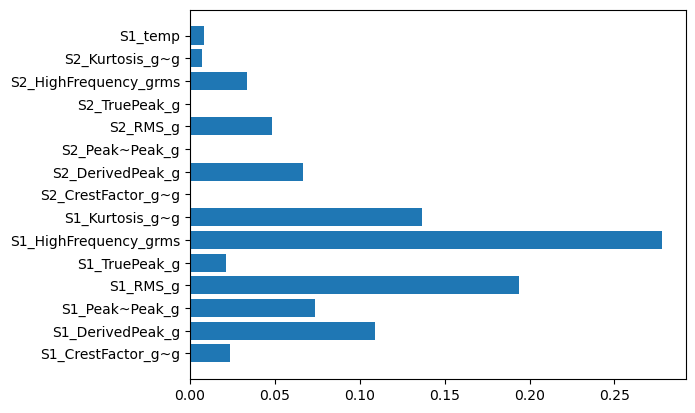

In [10]:


### Save/Load the model

# ## utility - save/load the model
# import os
# import joblib

# # to save
# joblib.dump(rf, data_path + '/random_forest_offset_RUL.joblib') 

# # to load
# rf = joblib.load(data_path + '/random_forest_offset_RUL.joblib')

### Evaluation

# y_pred = rf.predict(X_vals) ## using the untinted dataset!
    
y_prob = rf.predict_proba(X_vals)

macro_roc_auc_ovo = roc_auc_score(y_vals, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_vals, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_vals, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_vals, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)
## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313

# y_pred = rf.predict(X_test) ## using the untinted dataset!
    
y_prob = rf.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)
## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313

rf.feature_importances_

plt.barh(df.columns[:-1], rf.feature_importances_)

# Done with the RF PART!

In [11]:




from sklearn.preprocessing import StandardScaler,LabelBinarizer
lbz = LabelBinarizer()


scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
y_train=lbz.fit_transform(y_train)



scaler=StandardScaler()
X_vals=scaler.fit_transform(X_vals)
y_vals=lbz.fit_transform(y_vals)


scaler=StandardScaler()
X_test=scaler.fit_transform(X_test)
y_test=lbz.fit_transform(y_test)





In [12]:
# X_train,y_train

In [13]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [14]:

from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D,Flatten, Activation, Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D,Flatten, Activation
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from autosklearn.regression import AutoSklearnRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2,L1,L1L2
import tensorflow as tf



2023-07-01 14:59:08.473859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 14:59:09.164651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:



# MLP



path


# !rm -rf logs/fit/*
# !rm -rf /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16/*


log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# def scheduler(epoch, lr):
#       if epoch < 40:
#         lr=0.0001
#         return lr
#       else:
#         lr=0.00001
#         return lr #* tf.math.exp(-0.1)
# lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

es=EarlyStopping(
    monitor="val_loss",

    patience=6,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/OFFSET16/'+"weights-improvement-BEST_OFFSET.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    

    mode='auto',
    save_best_only=True, verbose=1)


# # checkpoint_filepath = "./tmp/checkpoint"

#scaler = MinMaxScaler()



%load_ext tensorboard
%reload_ext tensorboard







#TRAINING
tf.keras.backend.clear_session()



# self.model
model = Sequential()

# hidden layers
model.add(Dense(60, activation="relu", input_dim=X_train.shape[1],kernel_regularizer=L1L2(l2=0.001,l1=0.001))) #Better
#GOOD 60

model.add(Dropout(0.5))


model.add(Dense(30, activation="relu",kernel_regularizer=L2(l2=0.001)))  #Better
#GOOD 40
model.add(Dropout(0.5))

# model.add(Dense(40, activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation="relu",kernel_regularizer=L2(l2=0.001)))  #Better
# output layer
model.add(Dense(5, activation="softmax"))
              # softmax for probability, #values are sigmoid

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(
#         learning_rate=self.learning_rate),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )

# Compile the network :
# NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
# NN_model.summary()

# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# y_train

#FAST AI SEE IF TRIANING IMPROVES !
# 1420492

history=model.fit(X_train, y_train,epochs=13,batch_size=32,validation_data=(X_vals,y_vals) ,verbose=1,callbacks=[tensorboard_callback,lr,model_checkpoint_callback,es],)


logs/fit/20230701-145910
Epoch 1/13


2023-07-01 14:59:11.145291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30936 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-07-01 14:59:12.891856: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f70b0c20430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-01 14:59:12.891902: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-07-01 14:59:12.896747: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-01 14:59:13.076434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-01 14:59:13.600925: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled clus

4459/4476 [============================>.] - ETA: 0s - loss: 1.9579 - accuracy: 0.2297
Epoch 1: val_accuracy improved from -inf to 0.13095, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/OFFSET16/weights-improvement-BEST_OFFSET.h5
4476/4476 [==============================] - 14s 2ms/step - loss: 1.9577 - accuracy: 0.2298 - val_loss: 1.8206 - val_accuracy: 0.1309 - lr: 1.0000e-07
Epoch 2/13
4468/4476 [============================>.] - ETA: 0s - loss: 1.9411 - accuracy: 0.2353
Epoch 2: val_accuracy improved from 0.13095 to 0.15463, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/OFFSET16/weights-improvement-BEST_OFFSET.h5
4476/4476 [==============================] - 10s 2ms/step - loss: 1.9411 - accuracy: 0.2353 - val_loss: 1.7963 - val_accuracy: 0.1546 - lr: 2.1544e-07
Epoch 3/13
4453/4476 [============================>.] - ETA: 0s - loss: 1.9004 - accuracy: 0.2542
Epoch 3: val_accuracy improved from 0.15463 to 0.21185, saving model to /home/jose/FL_AM_Defect-

In [16]:
model.summary()

# model.save(path+'MLP_REG_RUL_16',save_format='h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                960       
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 155       
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [17]:



# loading the saved model
loaded_model = tf.keras.models.load_model('/home/jose/FL_AM_Defect-Detection/checkpoint/OFFSET16/weights-improvement-BEST_OFFSET.h5')





In [18]:
import visualkeras

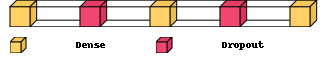

In [19]:

visualkeras.layered_view(loaded_model, legend=True,  draw_volume=True,spacing=50) 

In [30]:
from sklearn.metrics import classification_report


# y_pred = loaded_model.predict(X_test) ## using the untinted dataset!

y_prob = loaded_model.predict(X_test)
y_prob


1493/1493 [==============================] - 1s 767us/step


array([[9.9999356e-01, 1.7558657e-09, 5.0674498e-16, 5.9266781e-06,
        4.2077949e-07],
       [7.0274337e-09, 9.9999893e-01, 5.6875223e-07, 5.1907210e-07,
        3.0083256e-12],
       [9.9999201e-01, 1.8100527e-09, 6.1716160e-16, 7.7189452e-06,
        2.5123791e-07],
       ...,
       [9.9827302e-01, 4.5266602e-06, 1.0172724e-09, 1.5336857e-03,
        1.8878334e-04],
       [9.9988163e-01, 4.8841269e-08, 5.7726361e-13, 1.1640850e-04,
        1.8692594e-06],
       [4.1069798e-06, 9.9947268e-01, 4.1522327e-04, 1.0810338e-04,
        3.9006444e-08]], dtype=float32)

In [32]:
# # np.argmax(model.predict(X_test),axis=1)
# acc_score=classification_report(y_test, np.argmax(y_prob,axis=1))
# print("acc_score: ",acc_score)

In [33]:



macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)
## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313

One-vs-One ROC AUC scores:
0.998515 (macro),
0.998936 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.998515 (macro),
0.998936 (weighted by prevalence)
